# Stock price prediction with LSTM neural network using Keras

In this notebook, I will use time-series data of PFE price from 2010 to 2021
to forecast its price in the future using LSTM neural network.
PFE historical data are downloaded free of charge from https://www.investing.com/equities/pfizer-historical-data.
Data from csv sheet are loaded onto pandas dataframes.
Visualizations are performed with Plotly, an interactive graphing library.
This type of graph is well-suited for time-series data over a long period of time.
Tensorflow with Keras backend are used to constructed neural networks.
Lastly, hyperparameters tuning with Keras-tuner is performed to generate the best model.

### 1.Data exploration

#### 1.1. Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import IPython
from datetime import datetime,date,timedelta

In [2]:
#Loading historical data, convert datatime from string to numerical
pdf=pd.read_csv("D:\\Dropbox_dailescifi\\Dropbox\\pythonProject\\PFE Historical Data.csv",
                    index_col='Date',
                    usecols=["Date","Price"],
                    parse_dates=True,
                    infer_datetime_format=True,
                    keep_date_col=True
                    )
pdf

Price
Date             
2010-09-20  16.38
2010-09-21  16.25
2010-09-22  16.32
2010-09-23  16.15
2010-09-24  16.49
...           ...
2021-10-12  41.85
2021-10-13  41.42
2021-10-14  41.67
2021-10-15  41.49
2021-10-18  41.32

[2790 rows x 1 columns]

#### 1.2. Data visualization

In [3]:
#Plot BTC data with Plotly
import plotly.express as px
fig = px.line(pdf,x=pdf.index,y=pdf['Price'].values.reshape(2790),
              labels=dict(x='Date',y='Price in USD'))
fig.update_layout(title='Historical Data of PFE Price',
                  title_font_size=24,title_x=0.5)
fig.show()

#### 1.3. Data splitting

In [4]:
# I'll use a (60%, 20%, 20%) split for the training, validation, and test sets.
column_indices = {name: i for i, name in enumerate(pdf[:'2021-08-01'].columns)}
n = len(pdf[:'2021-08-01'])
train_df = pdf[:'2021-08-01'][:int(n*0.6)]
val_df = pdf[:'2021-08-01'][int(n*0.6):int(n*0.8)]
test_df = pdf[int(n*0.8):]
num_features = pdf[:'2021-08-01'].shape[1]
print (num_features,train_df,val_df,test_df)

1             Price
Date             
2010-09-20  16.38
2010-09-21  16.25
2010-09-22  16.32
2010-09-23  16.15
2010-09-24  16.49
...           ...
2017-03-21  32.47
2017-03-22  32.68
2017-03-23  32.51
2017-03-24  32.23
2017-03-27  32.40

[1641 rows x 1 columns]             Price
Date             
2017-03-28  32.38
2017-03-29  32.54
2017-03-30  32.56
2017-03-31  32.43
2017-04-03  32.46
...           ...
2019-05-23  39.74
2019-05-24  39.77
2019-05-28  39.72
2019-05-29  39.55
2019-05-30  39.72

[547 rows x 1 columns]             Price
Date             
2019-05-31  39.36
2019-06-03  39.74
2019-06-04  40.03
2019-06-05  40.27
2019-06-06  40.49
...           ...
2021-10-12  41.85
2021-10-13  41.42
2021-10-14  41.67
2021-10-15  41.49
2021-10-18  41.32

[602 rows x 1 columns]


#### 1.4. Data normalization

In [5]:
# Scaling needs to be done before training neural networks. I will use standard scaler
# z=(x-mean)/std
#The mean and standard deviation should only be computed using the training data so that
# the models have no access to the values in the validation and test sets
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### 2.Data generation

#### 2.1.Data windowing

In [6]:
'''In this process, data is divided into consecutive windows, each consists of :
1.Input
2.Label (prediction)
3.Offset (the time between input and label)
More details about data windowing can be found at
https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data'''
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

#### 2.2.Window splitting

In [7]:
# Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

#### 2.3.Create datasets

In [8]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

#### 2.4. Add properties to access train,val,test datasets

In [9]:
'''The WindowGenerator object holds training, validation and test data.
Add properties for accessing them as tf.data.Datasets using the above make_dataset method.
Also add a standard example batch for easy access and plotting'''
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


w1010= WindowGenerator(
    input_width=20, label_width=20, shift=1,
    label_columns=['Price'])
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Price'])
BATCH_SIZE=10
MAX_EPOCHS=25

### 3.Create plot function

In [10]:
import matplotlib.pyplot as plt
#Plot function
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} (normed)')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time (day)')

WindowGenerator.plot = plot

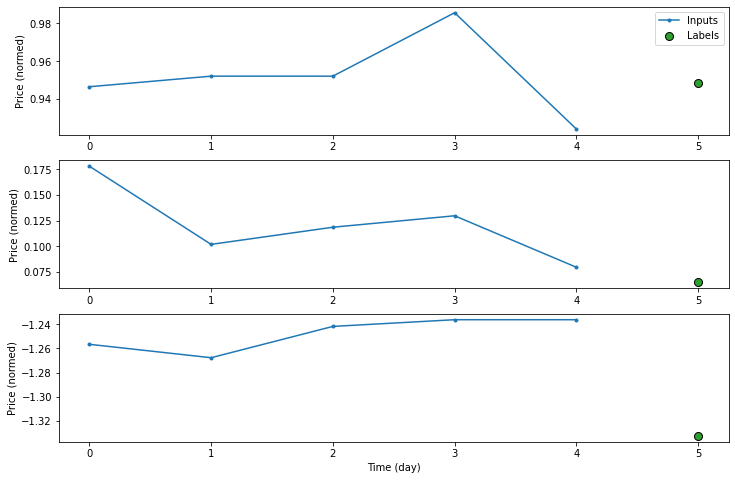

In [11]:
#Try the plot function
w1010.plot()

### 4.Create baseline model

#### 4.1.Construct model

In [12]:
# Before training lstm model, create baseline model which gives the same prediction as the label of 1 timestep before
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

#### 4.2.Compile, run, evaluate, visualize

In [13]:

#Instantiate and evaluate this model
baseline = Baseline(label_index=column_indices['Price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=tf.keras.metrics.MeanAbsoluteError())

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 963us/step - loss: 0.0056 - mean_absolute_error: 0.0525


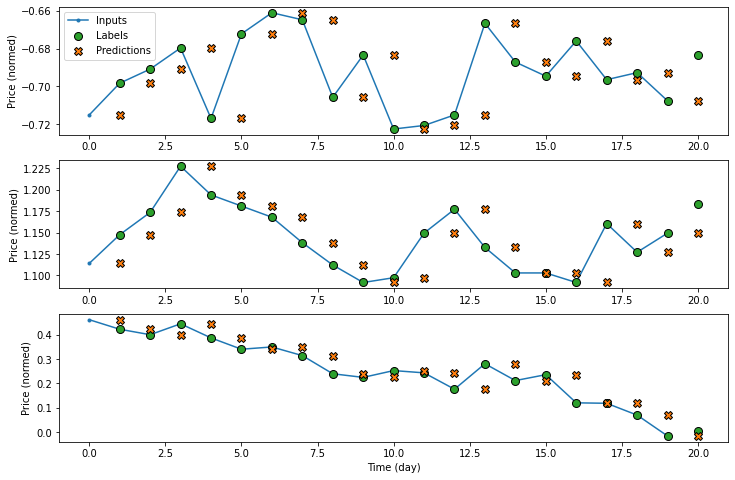

In [14]:
# Change the size of windows and plot
w1010.plot(baseline)

### 5.Construct LSTM model

#### 5.1.Define training function

In [15]:

def compile_and_fit(model, window, patience=5,allow_cudnn_kernel=True):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#### 5.2.Construct LSTM model
LSTM is a type of Recurrent Neural Network (RNN), which process a time series step-by-step,
maintaining an internal state from time-step to time-step.

In [16]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

#### 5.3.Compile, run, evaluate, visualize

53/53 [==============================] - 0s 3ms/step - loss: 0.0196 - mean_absolute_error: 0.0866


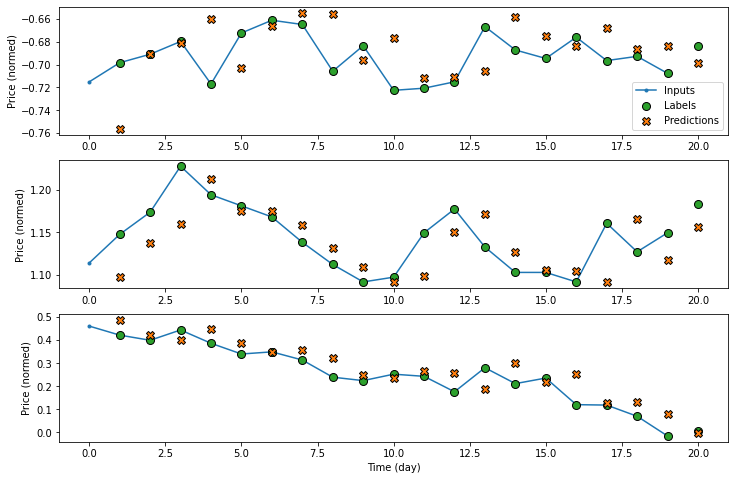

In [17]:

history = compile_and_fit(lstm_model, w1010)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w1010.val)
performance['LSTM'] = lstm_model.evaluate(w1010.test, verbose=0)
w1010.plot(lstm_model)

### 6.Compare performance of LSTM model to baseline model

Baseline       : 0.0788
LSTM           : 0.1268


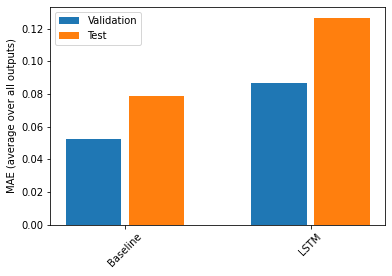

In [18]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

### 6.Hyperparameter tuning with keras-tuner

In [19]:
import os
import keras_tuner as kt
import keras

# Optimize hyperparameters of model with keras tuner
# Define model builder with ranges of hyperparameters
def deep_model_builder(hp,allow_cudnn_kernel=True):
    hp_units = hp.Int('units', min_value = 32, max_value =512, step = 32)
    hp_loss=hp.Choice('loss',values=['mean_squared_error','mean_absolute_error'])
    hp_activation=hp.Choice('activation',values=['relu','elu','sigmoid','tanh','softmax'])
    hp_dropout=hp.Choice('dropout',values=[0.1,0.5])
    deep_model_hp = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=hp_units,  activation=hp_activation,return_sequences=True),
    tf.keras.layers.Dropout(hp_dropout),
    tf.keras.layers.Dense(units=1, activation=hp_activation)
])
    opt_hp=hp.Choice('optimizer',values=['Adam','sgd'])
    deep_model_hp.compile(optimizer = opt_hp,
                loss = hp_loss,
                metrics = ['mean_absolute_error'])
    return deep_model_hp
#define tuner and start search
early_stopping= tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 5,mode= 'min')
tuner = kt.Hyperband(deep_model_builder,
                     objective = "val_loss",
                     max_epochs = MAX_EPOCHS,
                     factor = 3,
                     directory =os.path.join('D:/Data/Data/my_dir_'+ datetime.now().strftime("%Y%m%d-%H%M%S")),
                     project_name = os.path.join('D:/Data/Data/kerastuner_'+datetime.now().strftime("%Y%m%d-%H%M%S")))
tuner.search(w1010.train,epochs=MAX_EPOCHS,validation_data=w1010.val, callbacks=[early_stopping] )
best_hps = tuner.get_best_hyperparameters(num_trials = 3)[0]
print (f"""
The hyperparameter search is complete. The optimal number of units in the
LSTM layer is {best_hps.get('units')},
optimal loss function is {best_hps.get('loss')},
optimal dropout rate is {best_hps.get('dropout')},
optimal activation function is  {best_hps.get('activation')},
optimal optimizer is {best_hps.get('optimizer')}
""")

Trial 30 Complete [00h 02m 08s]
val_loss: 0.8484038710594177

Best val_loss So Far: 0.008896715939044952
Total elapsed time: 00h 43m 26s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the
LSTM layer is 416,
optimal loss function is mean_squared_error,
optimal dropout rate is 0.1,
optimal activation function is  relu,
optimal optimizer is Adam



53/53 [==============================] - 1s 12ms/step - loss: 0.0140 - mean_absolute_error: 0.0849

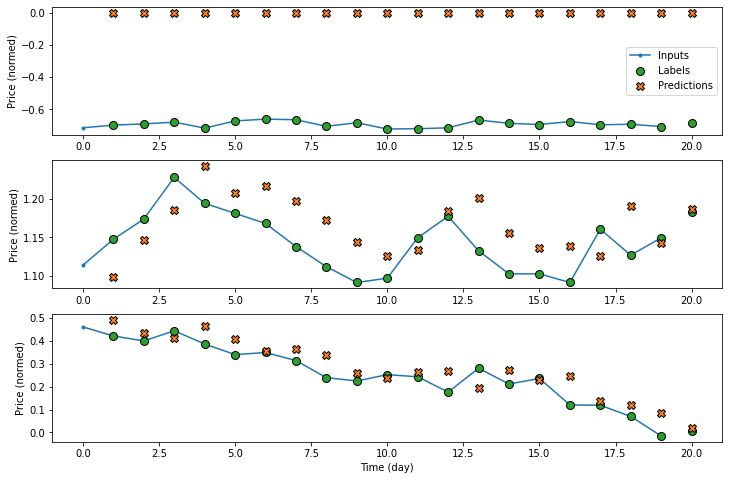

In [20]:
#fit model with best params
best_deep_model = tuner.hypermodel.build(best_hps)
history = compile_and_fit(best_deep_model, w1010)
IPython.display.clear_output()
val_performance['Tuned LSTM'] = best_deep_model.evaluate(w1010.val)
performance['Tuned LSTM'] = best_deep_model.evaluate(w1010.test, verbose=10)
print (best_deep_model.summary())
w1010.plot(best_deep_model)

### 7.Compare performance of LSTM model to baseline model

Baseline       : 0.0788
LSTM           : 0.1268
Tuned LSTM     : 0.1100


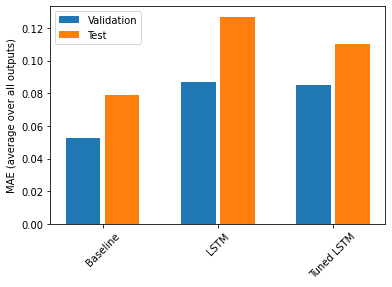

In [21]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

### 8.Conclusion
My conclusion is as follows:
1. It's unlikely that LSTM model can beat baseline model. In other words, if I predicted the stock price the day after
the same as it was the day before consistently, over a long period the time, I would beat LSTM model.
2. Tuning hyperparameters can greatly improve performance of LSTM model. But still, its performance can only
come close to baseline.
3. It's either LSTM is not a good model for stock price prediction or the stock price movement cannot be predicted
by solely historical price data. There should be many other factors involved in determining stock price. Increasing
training features might improve prediction accuracy.